In [ ]:
!pip install tikzplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.0 MB/s eta 0:00:00


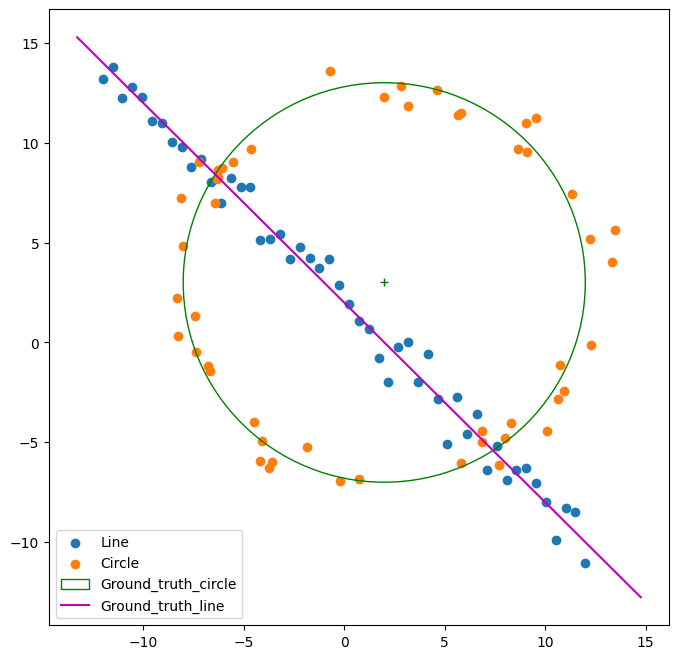

In [27]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg

import matplotlib.pyplot as plt
import tikzplotlib

# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')

plt.legend()
plt.show()

In [35]:
import numpy as np
from scipy.optimize import minimize

# RANSAC for Line Fitting
def ransac_line(X, line_max_iterations=100, line_threshold=1.0, line_data_fraction=0.4, line_sample=2):
    N = X.shape[0]
    line_data_points = int(line_data_fraction * N)
    line_best_error = np.inf
    best_line_model = []
    best_line_inliers = []

    def line_total_error(x, line_indices):
        a, b, d = x[0], x[1], x[2]
        return np.sum(np.square(a * X[line_indices, 0] + b * X[line_indices, 1] - d))

    def cons(x):
        return x[0] ** 2 + x[1] ** 2 - 1

    constraint = {'type': 'eq', 'fun': cons}

    def line_consensus_set(X, x, line_threshold):
        a, b, d = x[0], x[1], x[2]
        error = np.abs(a * X[:, 0] + b * X[:, 1] - d)
        return error < line_threshold

    print("--------------------------------------implementing RANSAC Line---------------------------------")
    for line_iteration in range(line_max_iterations):
        line_indices = np.random.randint(0, N, line_sample)
        x0 = np.array([1, 1, 0])

        res = minimize(line_total_error, x0=x0, args=(line_indices,), tol=1e-6, constraints=constraint)
        line_inliers = line_consensus_set(X, res.x, line_threshold)

        if np.sum(line_inliers) > line_data_points:
            x0 = res.x
            res = minimize(line_total_error, x0=x0, args=(line_inliers,), tol=1e-6, constraints=constraint)

            if res.fun < line_best_error:
                line_best_error = res.fun
                best_line_model = res.x
                best_line_inliers = line_inliers
                print(f"\niteration {line_iteration}")
                print(f"line_best_error {line_best_error}")
                print(f"best_line_indices {line_indices}")
                print(f"best_line_model {best_line_model}")
                print(f"no of inliers {np.sum(line_inliers)}")

    return best_line_model, best_line_inliers


In [36]:
# RANSAC for Circle Fitting
def ransac_circle(X, best_line_inliers, circle_threshold=1.0, max_circle_iterations=100, circle_sample=3, circle_num_data=35):
    line_outliers = np.where(best_line_inliers == False)[0]
    remnants = X[line_outliers]

    def circle_tls(x, indices):
        x0, y0, r = x
        x1, y1 = remnants[indices].T
        return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

    def circle_consensus_set(remnants, x, circle_threshold):
        distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
        return distances < circle_threshold

    circle_best_model = []
    circle_best_inliers = []
    circle_best_error = np.inf
    circle_best_indices = []

    print("\n--------------------------------------implementing RANSAC Circle---------------------------------")
    print(f"\nNumber of Elements in X: {X.shape[0]}")
    print(f"Number of Line Inliers: {np.sum(best_line_inliers)}")
    print(f"Remnants: {len(remnants)}")

    for circle_iteration in range(max_circle_iterations):
        circle_indices = np.random.randint(0, len(remnants), circle_sample)
        x0 = np.array([0, 0, 0])

        res = minimize(circle_tls, x0, args=circle_indices, tol=1e-6)
        circle_inliers = circle_consensus_set(remnants, res.x, circle_threshold)

        if np.sum(circle_inliers) > circle_num_data:
            x0 = res.x
            res = minimize(circle_tls, x0=x0, args=(circle_inliers,), tol=1e-6)

            if res.fun < circle_best_error:
                circle_best_error = res.fun
                circle_best_indices = circle_indices
                circle_best_model = res.x
                circle_best_inliers = circle_inliers
                print(f"\niteration {circle_iteration}")
                print(f"best_error {circle_best_error}")
                print(f"best_indices {circle_best_indices}")
                print(f"best_model {circle_best_model}")
                print(f"no of inliers {np.sum(circle_inliers)}")

    circle_best_inliers = np.array(circle_best_inliers[:len(remnants)])
    return circle_best_model, circle_best_inliers, circle_best_indices, remnants




--------------------------------------implementing RANSAC Line---------------------------------

iteration 3
line_best_error 12.76647702754598
best_line_indices [82 68]
best_line_model [0.71544237 0.69867175 1.36312543]
no of inliers 45

iteration 44
line_best_error 11.474058149754194
best_line_indices [53 77]
best_line_model [0.69591138 0.71812767 1.42391011]
no of inliers 45

iteration 90
line_best_error 10.737066164923608
best_line_indices [76 53]
best_line_model [0.6859041  0.72769195 1.56113506]
no of inliers 44

iteration 94
line_best_error 9.377194359863424
best_line_indices [19 77]
best_line_model [0.67441139 0.7383558  1.40276673]
no of inliers 41

--------------------------------------implementing RANSAC Circle---------------------------------

Number of Elements in X: 100
Number of Line Inliers: 41
Remnants: 59

iteration 10
best_error 5.325762878302483
best_indices [0 1 7]
best_model [ 2.18289604  3.23166708 10.35959116]
no of inliers 36


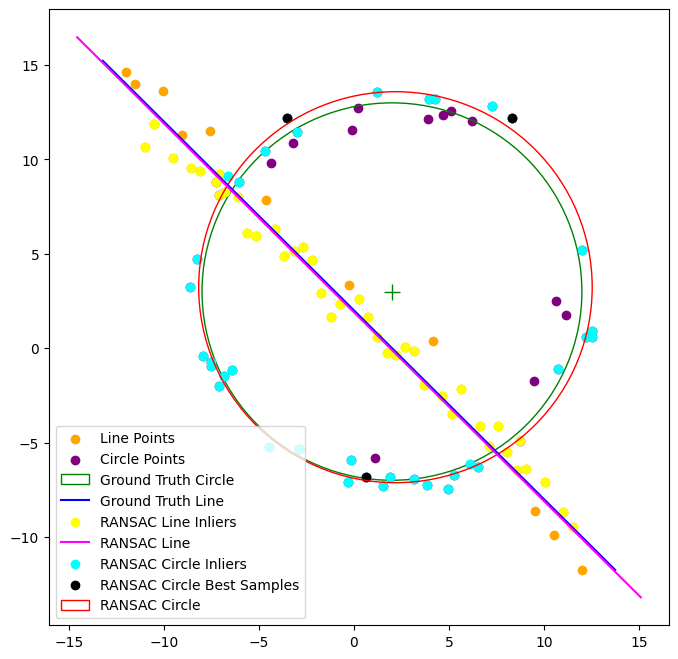

In [37]:
# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], color='orange', label='Line Points')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color='purple', label='Circle Points')

# Ground truth Circle
circle_get = plt.Circle((x0_gt, y0_gt), r, color='green', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_get)
ax.plot((x0_gt), (y0_gt), '+', color='green', markersize=12)

# Ground truth Line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='blue', label='Ground Truth Line')

# Perform RANSAC-based line and circle fitting
best_line_model, best_line_inliers = ransac_line(X)
circle_best_model, circle_best_inliers, circle_best_indices, remnants = ransac_circle(X, best_line_inliers)

# RANSAC Line
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], color='yellow', label='RANSAC Line Inliers')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_line_model[1] * x_ + best_line_model[2]) / best_line_model[1]
plt.plot(x_, y_, color='magenta', label='RANSAC Line')

# RANSAC Circle
ax.scatter(remnants[circle_best_inliers, 0], remnants[circle_best_inliers, 1], color='cyan', label='RANSAC Circle Inliers')
ax.scatter(remnants[circle_best_indices, 0], remnants[circle_best_indices, 1], color='black', label='RANSAC Circle Best Samples')

# Plot RANSAC Circle
circle = plt.Circle((circle_best_model[0], circle_best_model[1]), circle_best_model[2], color='red', fill=False, label='RANSAC Circle')
ax.add_patch(circle)

# Finalize plot
ax.legend()
plt.show()
